In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose

## Only run on weekends once

In [178]:
today = date.today()
day = today.weekday()
week_start = today - timedelta(days = day)
if day > 4:
    print(f'Ok to continue for week {week_start}')
else:
    raise Exception('Not on weekend, please wait until weekend to run.')
weekend = today

Ok to continue for week 2021-05-24


Edit below next weekend

In [179]:
print(today)

2021-05-29


In [180]:
cptv_week_df = pd.DataFrame()
rtt_week_df = pd.DataFrame()

for day_num in range(5):
    trading_day = today - timedelta(days = day-day_num)
    
    cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
    cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
    cptv_trading_day_df.drop(columns=['Open', 'High', 'Low'], inplace=True)
    cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
    cptv_week_df = cptv_week_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    
    rtt_trading_day_path = f'real_time_trades_data/AMZN_rtt_{trading_day}.csv'
    rtt_trading_day_df = pd.read_csv(rtt_trading_day_path)
    rtt_trading_day_df.drop(columns=['Unnamed: 0'], inplace=True)
    rtt_week_df = rtt_week_df.append(rtt_trading_day_df, ignore_index=True, sort=False)

rtt_week_df['NLS Price'] = rtt_week_df['NLS Price'].map(lambda x: x.lstrip('$ '))
rtt_week_df['NLS Price'] = pd.to_numeric(rtt_week_df['NLS Price'])
rtt_week_df['NLS Share Volume'] = rtt_week_df['NLS Share Volume'].str.replace(',', '')
rtt_week_df['NLS Share Volume'] = pd.to_numeric(rtt_week_df['NLS Share Volume'])

cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}')
rtt_week_csv = f'AMZN_rtt_{week_start}.csv'
rtt_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{rtt_week_csv}')

## Setting week start to 5/10/21

In [190]:
week_start = '2021-05-10'

In [210]:
cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)
rtt_week_csv = f'AMZN_rtt_{week_start}.csv'
rtt_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{rtt_week_csv}', header=0, index_col=0)

In [211]:
close_price_series = cptv_week_df.loc[:, 'Close']
cptv_week_df = cptv_week_df.assign(rolling_close = close_price_series.rolling(180, center=True).mean())
close_volume_series = cptv_week_df.loc[:, 'Volume']
cptv_week_df = cptv_week_df.assign(rolling_volume = close_volume_series.rolling(180, center=True).mean())

In [119]:
#Don't run
grouped_cptv_week_df = cptv_week_df.groupby(np.arange(len(cptv_week_df))//30).mean()
grouped_cptv_week_df = grouped_cptv_week_df.loc[np.repeat(grouped_cptv_week_df.index.values,30)]

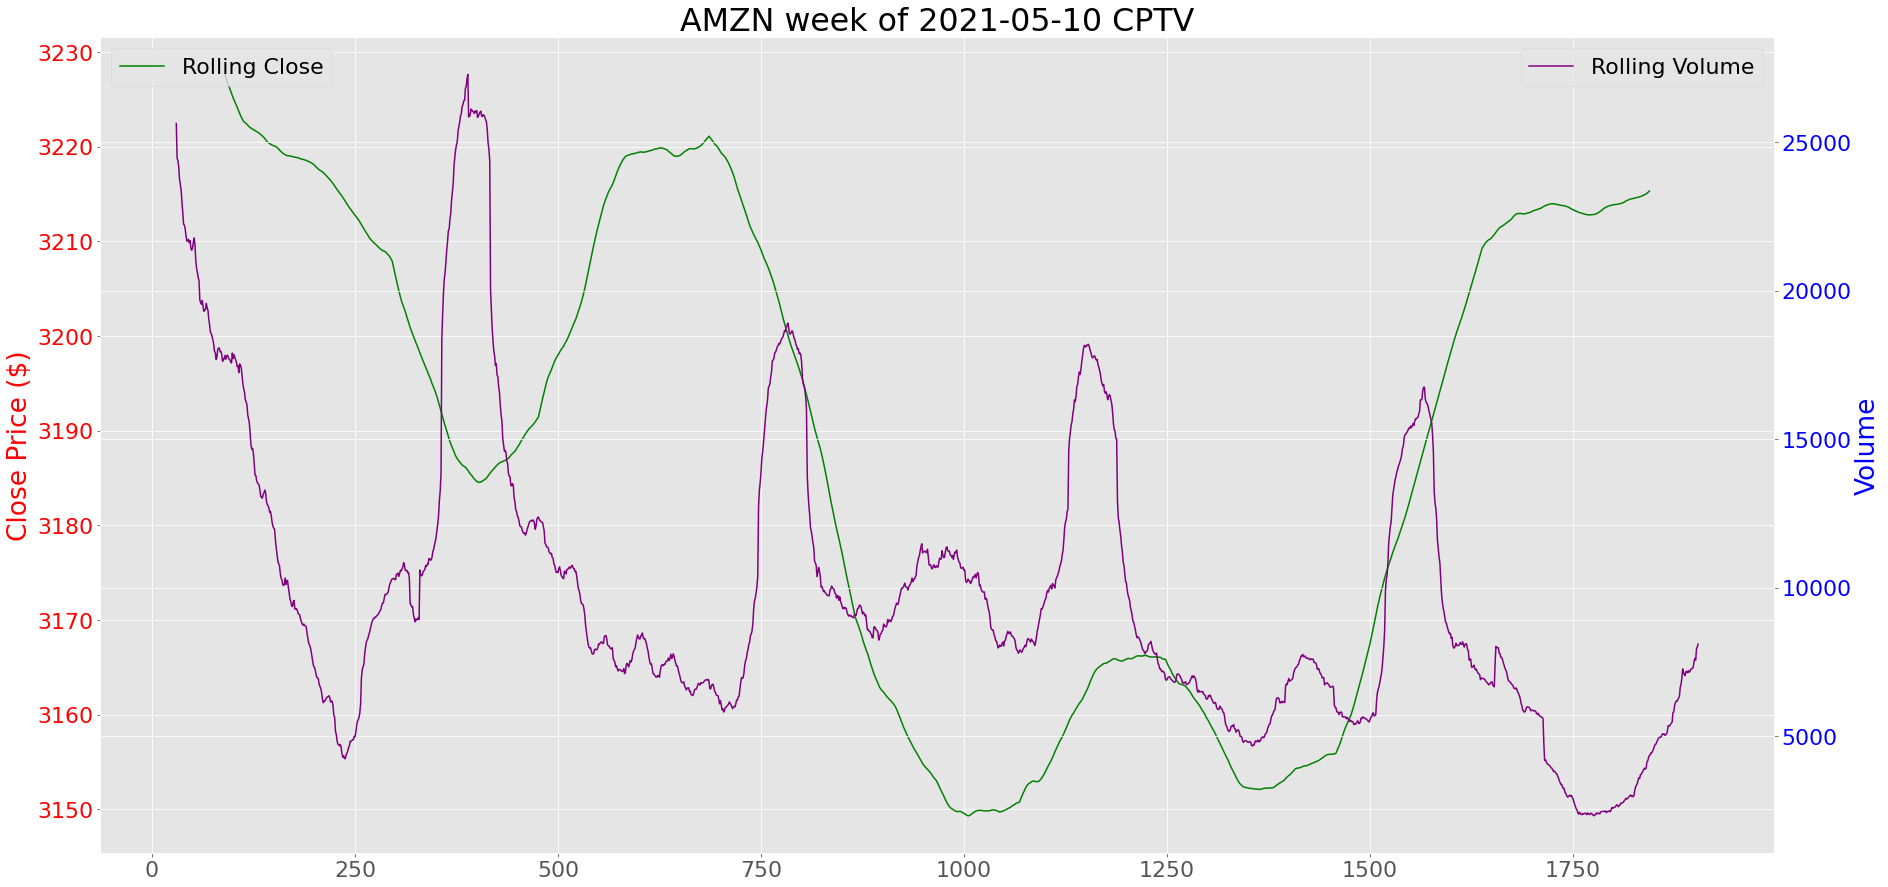

In [246]:
#date_array = cptv_week_df.loc[:, 'Date']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

#ax1.plot(date_array, cptv_week_df.loc[:, 'Close'], color='r', label='Close')
ax1.plot(cptv_week_df.index, cptv_week_df.loc[:, 'rolling_close'], color='g', label='Rolling Close')
ax1.set_ylabel('Close Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} CPTV')
ax1.tick_params(axis='y', labelcolor='r')
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
#ax2.plot(date_array, cptv_week_df.loc[:, 'Volume'], color='b', label='Volume')
ax2.plot(cptv_week_df.index, week_df.loc[:, 'rolling_volume'], color='purple', label='Rolling Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.legend()

plt.show()

In [168]:
cptv_week_df.set_index('Date')

,Close,Volume,rolling_close,rolling_volume
Date,,,,
2021-05-10 09-30,3273.1101,98924.0,NaN,NaN
2021-05-10 09-31,3269.8450,21831.0,NaN,NaN
2021-05-10 09-32,3259.7500,30404.0,NaN,NaN
2021-05-10 09-33,3259.0000,45721.0,NaN,NaN
2021-05-10 09-34,3258.0000,32843.0,NaN,NaN
...,...,...,...,...
2021-05-14 15-51,3222.4299,10377.0,NaN,NaN
2021-05-14 15-52,3224.2300,10812.0,NaN,NaN
2021-05-14 15-53,3228.8145,26557.0,NaN,NaN


In [199]:
cptv_roll_close_for_decompose = cptv_week_df[['rolling_close']].dropna().reset_index(drop=True)
cptv_roll_vol_for_decompose = cptv_week_df[['rolling_volume']].dropna().reset_index(drop=True)

In [201]:
cptv_roll_close_for_decompose.head()

,rolling_close
0,3241.993885
1,3241.225050
2,3240.544300
3,3240.046965
4,3239.537297


In [163]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

Datetime conversion not working?

In [219]:
datetime_object = datetime.strptime(cptv_copy['Date'], '%b %d %Y %I:%M%p')

,Date
0,2021-05-10 09-30
1,2021-05-10 09-31
2,2021-05-10 09-32
3,2021-05-10 09-33
4,2021-05-10 09-34


In [248]:
cptv_copy = cptv_week_df.copy()
print(cptv_copy.head())
cptv_copy.index = pd.to_datetime(cptv_copy['Date'], format='%Y-%m-%d %H-%M').drop(columns=['Date'])
cptv_copy = cptv_copy.drop(columns=['Date'])
print(cptv_copy.head(30))

               Date      Close   Volume  rolling_close  rolling_volume
0  2021-05-10 09-30  3273.1101  98924.0            NaN             NaN
1  2021-05-10 09-31  3269.8450  21831.0            NaN             NaN
2  2021-05-10 09-32  3259.7500  30404.0            NaN             NaN
3  2021-05-10 09-33  3259.0000  45721.0            NaN             NaN
4  2021-05-10 09-34  3258.0000  32843.0            NaN             NaN
                         Close   Volume  rolling_close  rolling_volume
Date                                                                  
2021-05-10 09:30:00  3273.1101  98924.0            NaN             NaN
2021-05-10 09:31:00  3269.8450  21831.0            NaN             NaN
2021-05-10 09:32:00  3259.7500  30404.0            NaN             NaN
2021-05-10 09:33:00  3259.0000  45721.0            NaN             NaN
2021-05-10 09:34:00  3258.0000  32843.0            NaN             NaN
2021-05-10 09:35:00  3261.7488  25957.0            NaN             NaN
2021-0

In [241]:
cptv_roll_close_for_decompose = cptv_copy[['rolling_close']].dropna()
cptv_roll_vol_for_decompose = cptv_copy[['rolling_volume']].dropna()

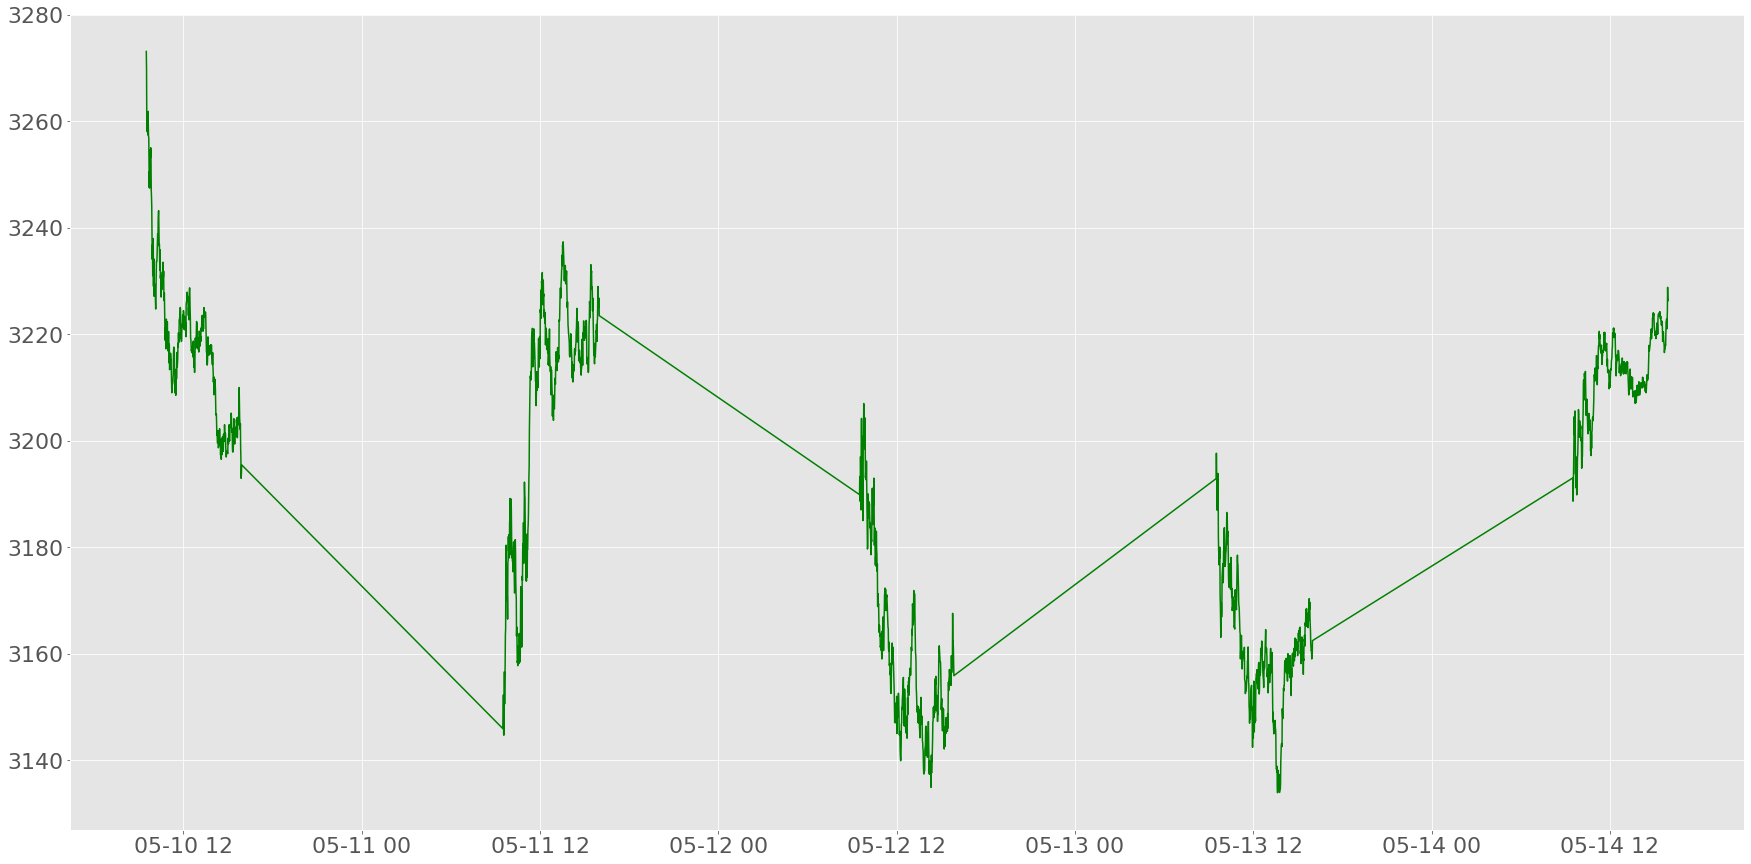

In [249]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.plot(cptv_copy.index, cptv_week_df.loc[:, 'rolling_close'], color='g', label='Rolling Close')

plt.show()

In [251]:
cptv_copy = cptv_week_df.copy()
cptv_roll_close_for_decompose = cptv_copy[['rolling_close']].dropna()

In [260]:
test = seasonal_decompose(cptv_roll_close_for_decompose, model='additive', period=390)
print(test.observed.shape)
print(test.trend.shape)
print(test.seasonal.shape)
print(test.resid.shape)
print(type(test.observed))

(1755,)
(1755,)
(1755,)
(1755,)
<class 'pandas.core.series.Series'>


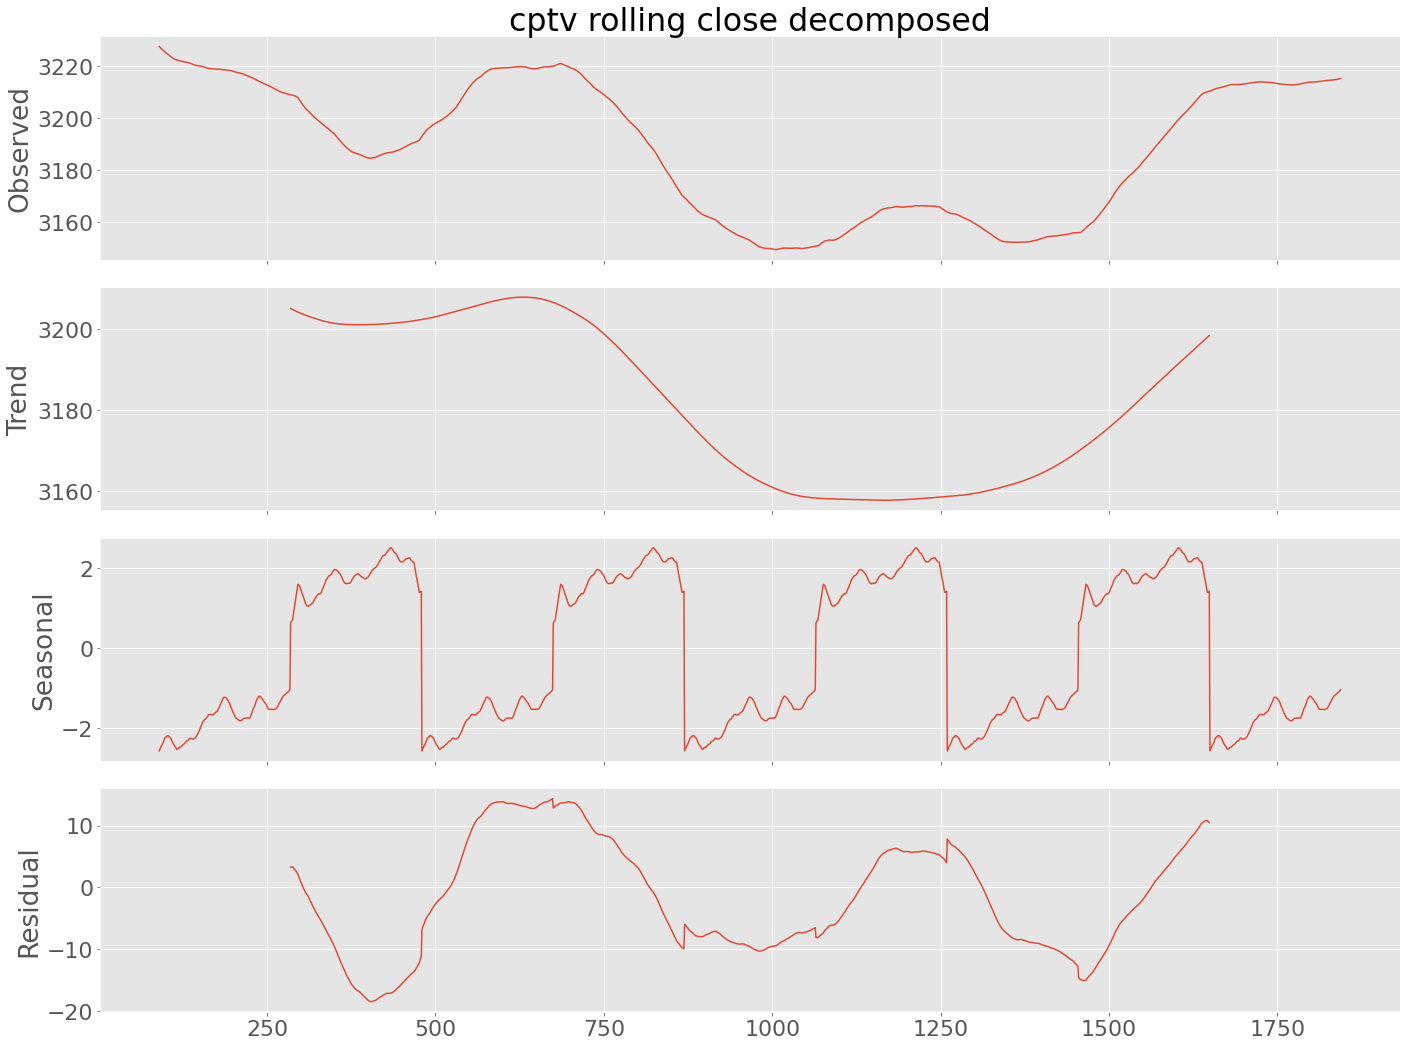

In [252]:
fig, axes = plt.subplots(nrows = 4, sharex = True, figsize=(20,15))
decomposed_cptv_roll_close = seasonal_decompose(cptv_roll_close_for_decompose, model='additive', period=390)

plotseasonal(decomposed_cptv_roll_close, axes[:])

axes[0].set_title('cptv rolling close decomposed')
plt.tight_layout()
plt.show()

In [ ]:
seasonal_decompose(cptv_roll_close_for_decompose, model='additive', period=390)

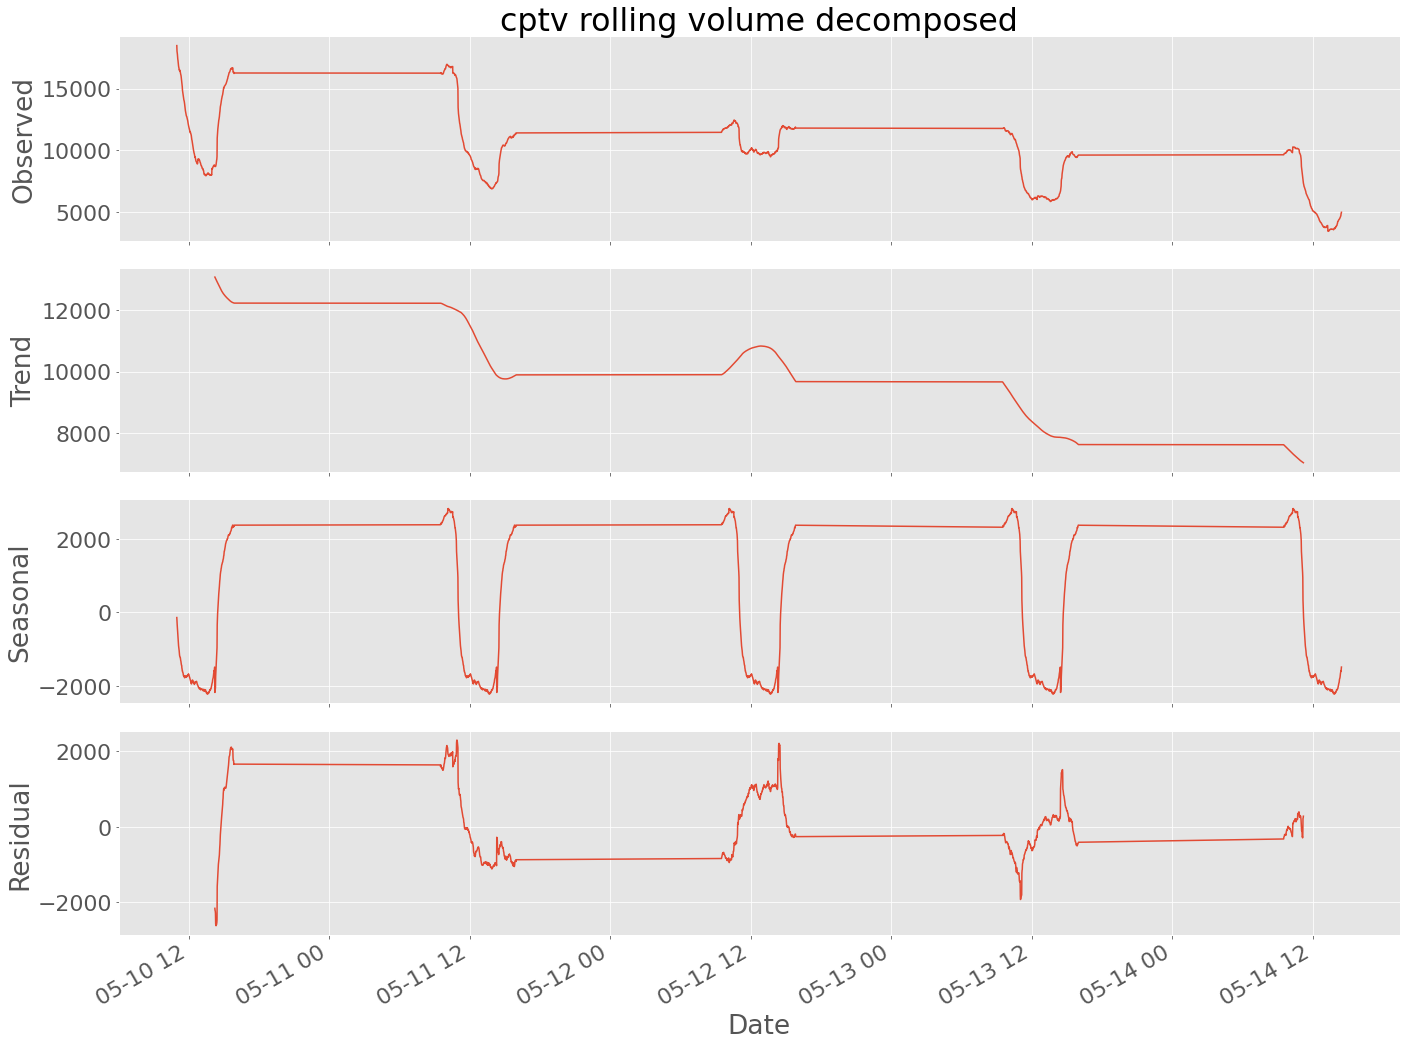

In [238]:
fig, axes = plt.subplots(nrows = 4, sharex = True, figsize=(20,15))
decomposed_cptv_roll_vol = seasonal_decompose(cptv_roll_vol_for_decompose, model='additive', period=390)

plotseasonal(decomposed_cptv_roll_vol, axes[:])

axes[0].set_title('cptv rolling volume decomposed')
plt.tight_layout()
plt.show()

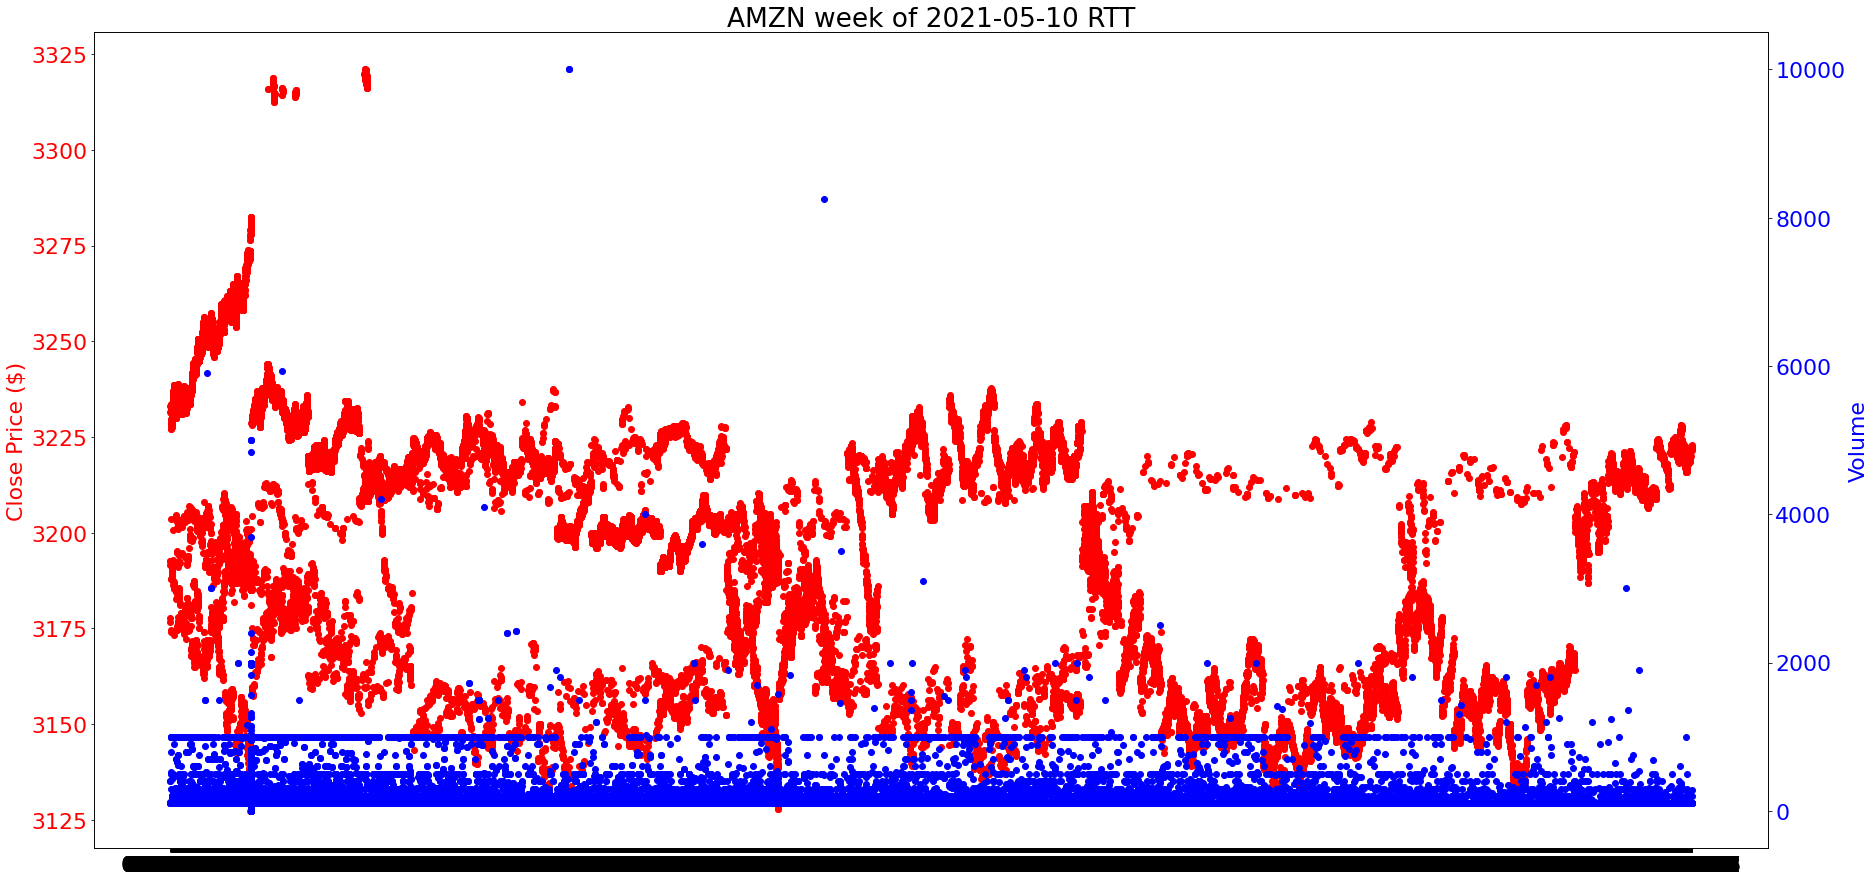

In [47]:
date_array = rtt_week_df.loc[:, 'NLS Time (ET)']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.scatter(date_array, rtt_week_df.loc[:, 'NLS Price'], color='r', alpha=0.5, label='NLS Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} RTT')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.scatter(date_array, rtt_week_df.loc[:, 'NLS Share Volume'], color='b', alpha=0.5, label='NLS Share Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.show()